In [1]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import numpy as np
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

In [3]:
def model_input(state_size):
    #states = tf.placeholder(tf.float32, [None, *state_size], name='states')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    rates = tf.placeholder(tf.float32, [None], name='rates')
    return states, actions, targetQs, rates

In [4]:
# Generator/Controller: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [5]:
def discriminator(states, actions, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=action_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        nl1_fused = tf.concat(axis=1, values=[nl1, actions])
        h2 = tf.layers.dense(inputs=nl1_fused, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
                
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        #predictions = tf.nn.softmax(logits)

        # return rewards logits
        return logits

In [7]:
def model_loss(action_size, hidden_size, states, actions, targetQs, rates):
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    gQs = discriminator(actions=actions_logits, hidden_size=hidden_size, states=states)
    rates = tf.reshape(rates, shape=[-1, 1])
    gloss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs, # GAN
                                                                   labels=rates)) # 0-1
    targetQs = tf.reshape(targetQs, shape=[-1, 1])
    gloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs, # GAN
                                                                    labels=tf.nn.sigmoid(targetQs))) # 0-1
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    dQs = discriminator(actions=actions_labels, hidden_size=hidden_size, states=states, reuse=True)
    dloss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dQs, # GAN
                                                                   labels=rates)) # 0-1
    dloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dQs, # GAN
                                                                    labels=tf.nn.sigmoid(targetQs))) # 0-1
    actions_pred = tf.argmax(input=actions_logits, axis=1, output_type=actions.dtype)
    mask_notequal = tf.not_equal(x=actions_pred, y=actions)
    gQs_notequal = tf.boolean_mask(mask=mask_notequal, tensor=gQs)
    dloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs_notequal, # GAN
                                                                    labels=tf.zeros_like(gQs_notequal))) # 0-1
    mask_equal = tf.equal(x=actions_pred, y=actions)
    gQs_equal = tf.boolean_mask(mask=mask_equal, tensor=gQs)
    #     rates_equal = tf.boolean_mask(mask=mask_equal, tensor=rates)
    #     dloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs_equal, # GAN
    #                                                                     labels=rates_equal)) # 0-1
    #     targetQs_equal = tf.boolean_mask(mask=mask_equal, tensor=targetQs)
    #     dloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs_equal, # GAN
    #                                                                     labels=tf.nn.sigmoid(targetQs_equal))) # 0-1
    glossQ = tf.reduce_mean(tf.square(gQs - targetQs)) # DQN
    dlossQ = tf.reduce_mean(tf.square(dQs - targetQs)) # DQN
    return actions_logits, gQs, gloss, dloss, glossQ, dlossQ, gQs_notequal, gQs_equal

In [8]:
# Optimizating/training/learning G & D
def model_opt(g_loss, d_loss, g_learning_rate, d_learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        g_opt = tf.train.AdamOptimizer(g_learning_rate).minimize(g_loss, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(d_learning_rate).minimize(d_loss, var_list=d_vars)
    return g_opt, d_opt

In [9]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, g_learning_rate, d_learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs, self.rates = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.Qs_logits, self.g_loss, self.d_loss, self.g_lossQ, self.d_lossQ, self.gQs_notequal, self.gQs_equal = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, targetQs=self.targetQs, rates=self.rates) # model input
        
        # Update the model: backward pass and backprop
        self.g_opt, self.d_opt = model_opt(g_loss=self.g_loss, d_loss=self.d_loss,
                                           g_learning_rate=g_learning_rate, 
                                           d_learning_rate=d_learning_rate)

In [10]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size) # data batch
        self.rates = deque(maxlen=max_size) # rates
#     def sample(self, batch_size):
#         idx = np.random.choice(np.arange(len(self.buffer)), # ==  self.rates
#                                size=batch_size, 
#                                replace=False)
#         return [self.buffer[ii] for ii in idx], [self.rates[ii] for ii in idx]

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [11]:
env.observation_space, env.action_space

(Box(4,), Discrete(2))

In [12]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01           # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4
action_size = 2
hidden_size = 4*2             # number of units in each Q-network hidden layer
g_learning_rate = 1e-4         # Q-network learning rate
d_learning_rate = 1e-4         # Q-network learning rate

# Memory parameters
memory_size = int(1e5)            # memory capacity
batch_size = int(1e3)             # experience mini-batch size: 200/500 a successfull episode size
gamma = 0.99                   # future reward discount

In [13]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, state_size=state_size, hidden_size=hidden_size,
              g_learning_rate=g_learning_rate, d_learning_rate=d_learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

/home/arasdar/miniconda3/envs/env/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [14]:
state = env.reset()
total_reward = 0
num_step = 0
for _ in range(memory_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    memory.buffer.append([state, action, next_state, reward, float(done)])
    memory.rates.append(-1) # empty
    num_step += 1 # memory incremented
    total_reward += reward
    state = next_state
    if done is True:
        state = env.reset()
        rate = total_reward/500
        total_reward = 0 # reset
        for idx in range(num_step): # episode length
            if memory.rates[-1-idx] == -1:
                memory.rates[-1-idx] = rate
        num_step = 0 # reset

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [ ]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list, rewards_list = [], []
gloss_list, dloss_list = [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window

    # Training episodes/epochs
    for ep in range(1111*3):
        total_reward = 0 # each episode
        gloss_batch, dloss_batch, glossQ_batch, dlossQ_batch= [], [], [], []
        state = env.reset() # each episode
        num_step = 0 # each episode

        # Training steps/batches
        while True:
            # Explore (Env) or Exploit (Model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
            else:
                action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
                action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([state, action, next_state, reward, float(done)])
            memory.rates.append(-1) # empty
            num_step += 1 # momory added
            total_reward += reward
            state = next_state
            
            # Rating the memory
            if done is True:
                rate = total_reward/500 # update rate at the end/ when episode is done
                for idx in range(num_step): # episode length
                    if memory.rates[-1-idx] == -1: # double-check the landmark/marked indexes
                        memory.rates[-1-idx] = rate # rate the trajectory/data
                        
            # Training with the maxrated minibatch
            batch = memory.buffer
            percentage = 0.9
            #for idx in range(memory_size// batch_size):
            idx_arr = np.arange(memory_size// batch_size)
            idx = np.random.choice(idx_arr)
            states = np.array([each[0] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            actions = np.array([each[1] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            next_states = np.array([each[2] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            rewards = np.array([each[3] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            dones = np.array([each[4] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            rates = np.array(memory.rates)[idx*batch_size:(idx+1)*batch_size]
            #print(states.shape, actions.shape, next_states.shape, rewards.shape, dones.shape, rates.shape)
            states = states[rates >= (np.max(rates)*percentage)]
            actions = actions[rates >= (np.max(rates)*percentage)]
            next_states = next_states[rates >= (np.max(rates)*percentage)]
            rewards = rewards[rates >= (np.max(rates)*percentage)]
            dones = dones[rates >= (np.max(rates)*percentage)]
            rates = rates[rates >= (np.max(rates)*percentage)]
            #print(states.shape, actions.shape, next_states.shape, rewards.shape, dones.shape, rates.shape)
            nextQs_logits = sess.run(model.Qs_logits, feed_dict = {model.states: next_states})
            #nextQs = np.max(nextQs_logits, axis=1) * (1-dones) # DQN
            nextQs = nextQs_logits.reshape([-1]) * (1-dones) # DPG
            targetQs = rewards + (gamma * nextQs)
            dloss, _, glossQ, dlossQ = sess.run([model.d_loss, model.d_opt, 
                                                 model.g_lossQ, model.d_lossQ],
                                                feed_dict = {model.states: states, 
                                                             model.actions: actions,
                                                             model.targetQs: targetQs, 
                                                             model.rates: rates})
            gloss, _, gQs_notequal, gQs_equal = sess.run([model.g_loss, model.g_opt, 
                                                          model.gQs_notequal, model.gQs_equal], 
                                              feed_dict = {model.states: states, 
                                                           model.actions: actions,
                                                           model.targetQs: targetQs, 
                                                           model.rates: rates})
            #if len(gQs_nonequal) != len(nextQs):
            # if dloss is np.nan:            
            #     print(gQs_notequal.shape, gQs_notequal.dtype)
            #     print(gQs_equal.shape, gQs_equal.dtype)
            #     print(nextQs.shape)
            gloss_batch.append(gloss)
            dloss_batch.append(dloss)
            glossQ_batch.append(glossQ)
            dlossQ_batch.append(dlossQ)
            if done is True:
                break
                
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{:.4f}'.format(total_reward),
              'rate:{:.4f}'.format(rate),
              'gloss:{:.4f}'.format(np.mean(gloss_batch)),
              'dloss:{:.4f}'.format(np.mean(dloss_batch)),
              'glossQ:{:.4f}'.format(np.mean(glossQ_batch)),
              'dlossQ:{:.4f}'.format(np.mean(dlossQ_batch)),
              'exploreP:{:.4f}'.format(explore_p))

        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        gloss_list.append([ep, np.mean(gloss_batch)])
        dloss_list.append([ep, np.mean(dloss_batch)])
        
        # Break episode/epoch loop
        ## Option 1: Solve the First Version
        #The task is episodic, and in order to solve the environment, 
        #your agent must get an average score of +30 over 100 consecutive episodes.
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:19.0000 R:19.0000 rate:0.0380 gloss:1.3858 dloss:2.0559 glossQ:1.0011 dlossQ:1.3932 exploreP:0.9981
Episode:1 meanR:18.0000 R:17.0000 rate:0.0340 gloss:1.3832 dloss:2.0477 glossQ:1.0019 dlossQ:1.3962 exploreP:0.9964
Episode:2 meanR:16.6667 R:14.0000 rate:0.0280 gloss:1.3819 dloss:2.0403 glossQ:1.0025 dlossQ:1.3764 exploreP:0.9951
Episode:3 meanR:16.2500 R:15.0000 rate:0.0300 gloss:1.3794 dloss:2.0332 glossQ:1.0088 dlossQ:1.3714 exploreP:0.9936
Episode:4 meanR:16.4000 R:17.0000 rate:0.0340 gloss:1.3775 dloss:2.0271 glossQ:1.0042 dlossQ:1.3526 exploreP:0.9919
Episode:5 meanR:16.5000 R:17.0000 rate:0.0340 gloss:1.3744 dloss:2.0106 glossQ:1.0069 dlossQ:1.3410 exploreP:0.9902
Episode:6 meanR:21.4286 R:51.0000 rate:0.1020 gloss:1.3701 dloss:1.9940 glossQ:1.0082 dlossQ:1.3036 exploreP:0.9853
Episode:7 meanR:20.2500 R:12.0000 rate:0.0240 gloss:1.3593 dloss:1.9588 glossQ:1.0155 dlossQ:1.2414 exploreP:0.9841
Episode:8 meanR:20.2222 R:20.0000 rate:0.0400 gloss:1.3612 dloss:nan glo

Episode:71 meanR:21.7361 R:15.0000 rate:0.0300 gloss:1.2143 dloss:1.4284 glossQ:1.4122 dlossQ:1.2910 exploreP:0.8566
Episode:72 meanR:21.5753 R:10.0000 rate:0.0200 gloss:1.2299 dloss:1.4520 glossQ:1.0937 dlossQ:1.0142 exploreP:0.8557
Episode:73 meanR:21.5270 R:18.0000 rate:0.0360 gloss:1.1829 dloss:1.3955 glossQ:1.1338 dlossQ:1.0869 exploreP:0.8542
Episode:74 meanR:21.4800 R:18.0000 rate:0.0360 gloss:1.1967 dloss:1.4393 glossQ:1.1499 dlossQ:1.1714 exploreP:0.8527
Episode:75 meanR:21.4868 R:22.0000 rate:0.0440 gloss:1.1807 dloss:1.4073 glossQ:1.1244 dlossQ:1.1362 exploreP:0.8508
Episode:76 meanR:21.5844 R:29.0000 rate:0.0580 gloss:1.1934 dloss:1.4191 glossQ:1.1272 dlossQ:1.1702 exploreP:0.8484
Episode:77 meanR:21.4872 R:14.0000 rate:0.0280 gloss:1.1844 dloss:1.4168 glossQ:1.1177 dlossQ:1.1965 exploreP:0.8472
Episode:78 meanR:21.3671 R:12.0000 rate:0.0240 gloss:1.1946 dloss:1.4236 glossQ:1.1430 dlossQ:1.2597 exploreP:0.8462
Episode:79 meanR:21.2750 R:14.0000 rate:0.0280 gloss:1.1698 dlos

Episode:141 meanR:17.9600 R:13.0000 rate:0.0260 gloss:1.1051 dloss:1.2452 glossQ:1.1460 dlossQ:0.9932 exploreP:0.7639
Episode:142 meanR:18.1200 R:32.0000 rate:0.0640 gloss:1.1110 dloss:1.2550 glossQ:1.1953 dlossQ:1.0409 exploreP:0.7615
Episode:143 meanR:18.0300 R:25.0000 rate:0.0500 gloss:1.1110 dloss:1.2546 glossQ:1.1691 dlossQ:1.0216 exploreP:0.7596
Episode:144 meanR:17.7900 R:23.0000 rate:0.0460 gloss:1.0857 dloss:1.2259 glossQ:1.1642 dlossQ:1.0042 exploreP:0.7579
Episode:145 meanR:17.6400 R:13.0000 rate:0.0260 gloss:1.1189 dloss:1.2565 glossQ:1.1543 dlossQ:0.9970 exploreP:0.7570
Episode:146 meanR:17.6000 R:20.0000 rate:0.0400 gloss:1.1333 dloss:1.2722 glossQ:1.3147 dlossQ:1.1508 exploreP:0.7555
Episode:147 meanR:17.3300 R:12.0000 rate:0.0240 gloss:1.1319 dloss:1.2662 glossQ:1.1388 dlossQ:0.9592 exploreP:0.7546
Episode:148 meanR:17.2100 R:10.0000 rate:0.0200 gloss:1.0979 dloss:1.2354 glossQ:1.1656 dlossQ:0.9904 exploreP:0.7538
Episode:149 meanR:17.4200 R:32.0000 rate:0.0640 gloss:1.

Episode:211 meanR:16.4200 R:27.0000 rate:0.0540 gloss:1.1212 dloss:1.2890 glossQ:1.1580 dlossQ:1.0709 exploreP:0.6830
Episode:212 meanR:16.4300 R:15.0000 rate:0.0300 gloss:1.1534 dloss:1.3167 glossQ:1.1462 dlossQ:1.0645 exploreP:0.6820
Episode:213 meanR:16.1900 R:18.0000 rate:0.0360 gloss:1.1380 dloss:1.3048 glossQ:1.1400 dlossQ:1.0508 exploreP:0.6808
Episode:214 meanR:16.2500 R:18.0000 rate:0.0360 gloss:1.1485 dloss:1.3092 glossQ:1.1450 dlossQ:1.0298 exploreP:0.6795
Episode:215 meanR:16.2100 R:16.0000 rate:0.0320 gloss:1.1305 dloss:1.2910 glossQ:1.1492 dlossQ:1.0376 exploreP:0.6785
Episode:216 meanR:16.2500 R:20.0000 rate:0.0400 gloss:1.1270 dloss:1.2882 glossQ:1.1840 dlossQ:1.0722 exploreP:0.6771
Episode:217 meanR:16.1800 R:18.0000 rate:0.0360 gloss:1.1265 dloss:1.2901 glossQ:1.1443 dlossQ:1.0354 exploreP:0.6759
Episode:218 meanR:16.1700 R:11.0000 rate:0.0220 gloss:1.1271 dloss:1.2900 glossQ:1.1605 dlossQ:1.0344 exploreP:0.6752
Episode:219 meanR:16.1700 R:10.0000 rate:0.0200 gloss:1.

Episode:281 meanR:13.6100 R:9.0000 rate:0.0180 gloss:1.0908 dloss:1.2357 glossQ:1.2254 dlossQ:1.0698 exploreP:0.6235
Episode:282 meanR:13.6100 R:10.0000 rate:0.0200 gloss:1.1208 dloss:1.2681 glossQ:1.1428 dlossQ:0.9916 exploreP:0.6228
Episode:283 meanR:13.5900 R:10.0000 rate:0.0200 gloss:1.1108 dloss:1.2626 glossQ:1.1778 dlossQ:1.0397 exploreP:0.6222
Episode:284 meanR:13.5400 R:9.0000 rate:0.0180 gloss:1.1069 dloss:1.2580 glossQ:1.1700 dlossQ:1.0426 exploreP:0.6217
Episode:285 meanR:13.5300 R:10.0000 rate:0.0200 gloss:1.1120 dloss:1.2624 glossQ:1.1651 dlossQ:1.0420 exploreP:0.6211
Episode:286 meanR:13.6000 R:15.0000 rate:0.0300 gloss:1.1745 dloss:1.3228 glossQ:1.6648 dlossQ:1.5237 exploreP:0.6202
Episode:287 meanR:13.5900 R:14.0000 rate:0.0280 gloss:1.1099 dloss:1.2605 glossQ:1.1612 dlossQ:1.0262 exploreP:0.6193
Episode:288 meanR:13.5200 R:11.0000 rate:0.0220 gloss:1.1308 dloss:1.2828 glossQ:1.1549 dlossQ:1.0381 exploreP:0.6186
Episode:289 meanR:13.5000 R:12.0000 rate:0.0240 gloss:1.10

Episode:351 meanR:12.8700 R:11.0000 rate:0.0220 gloss:1.0700 dloss:1.2028 glossQ:1.2216 dlossQ:1.0432 exploreP:0.5708
Episode:352 meanR:12.9700 R:20.0000 rate:0.0400 gloss:1.0849 dloss:1.2192 glossQ:1.2066 dlossQ:1.0342 exploreP:0.5696
Episode:353 meanR:12.9900 R:15.0000 rate:0.0300 gloss:1.1108 dloss:1.2436 glossQ:1.2020 dlossQ:1.0268 exploreP:0.5688
Episode:354 meanR:12.9800 R:10.0000 rate:0.0200 gloss:1.1027 dloss:1.2407 glossQ:1.1626 dlossQ:1.0034 exploreP:0.5682
Episode:355 meanR:12.8800 R:9.0000 rate:0.0180 gloss:1.0857 dloss:1.2241 glossQ:1.1901 dlossQ:1.0321 exploreP:0.5677
Episode:356 meanR:12.9000 R:13.0000 rate:0.0260 gloss:1.1126 dloss:1.2493 glossQ:1.1712 dlossQ:1.0050 exploreP:0.5670
Episode:357 meanR:12.8900 R:12.0000 rate:0.0240 gloss:1.1180 dloss:1.2615 glossQ:1.1802 dlossQ:1.0280 exploreP:0.5664
Episode:358 meanR:12.8100 R:10.0000 rate:0.0200 gloss:1.0932 dloss:1.2352 glossQ:1.1935 dlossQ:1.0388 exploreP:0.5658
Episode:359 meanR:12.8700 R:16.0000 rate:0.0320 gloss:1.1

Episode:421 meanR:12.5600 R:8.0000 rate:0.0160 gloss:1.1440 dloss:1.2841 glossQ:1.1590 dlossQ:0.9720 exploreP:0.5246
Episode:422 meanR:12.5700 R:10.0000 rate:0.0200 gloss:1.0990 dloss:1.2451 glossQ:1.1851 dlossQ:1.0130 exploreP:0.5241
Episode:423 meanR:12.6200 R:16.0000 rate:0.0320 gloss:1.0991 dloss:1.2488 glossQ:1.1784 dlossQ:1.0156 exploreP:0.5233
Episode:424 meanR:12.6100 R:13.0000 rate:0.0260 gloss:1.1427 dloss:1.2846 glossQ:1.1619 dlossQ:0.9884 exploreP:0.5226
Episode:425 meanR:12.5800 R:10.0000 rate:0.0200 gloss:1.1136 dloss:1.2586 glossQ:1.1647 dlossQ:1.0080 exploreP:0.5221
Episode:426 meanR:12.4300 R:12.0000 rate:0.0240 gloss:1.1213 dloss:1.2654 glossQ:1.1932 dlossQ:1.0393 exploreP:0.5215
Episode:427 meanR:12.3700 R:12.0000 rate:0.0240 gloss:1.1157 dloss:1.2570 glossQ:1.2860 dlossQ:1.1143 exploreP:0.5209
Episode:428 meanR:12.4000 R:13.0000 rate:0.0260 gloss:1.1162 dloss:1.2634 glossQ:1.1693 dlossQ:1.0142 exploreP:0.5202
Episode:429 meanR:12.3800 R:9.0000 rate:0.0180 gloss:1.10

Episode:491 meanR:11.8300 R:11.0000 rate:0.0220 gloss:1.1478 dloss:1.2879 glossQ:1.1539 dlossQ:0.9957 exploreP:0.4840
Episode:492 meanR:11.8200 R:11.0000 rate:0.0220 gloss:1.1108 dloss:1.2537 glossQ:1.1747 dlossQ:1.0114 exploreP:0.4835
Episode:493 meanR:11.8500 R:13.0000 rate:0.0260 gloss:1.1049 dloss:1.2498 glossQ:1.1859 dlossQ:1.0434 exploreP:0.4829
Episode:494 meanR:11.9700 R:22.0000 rate:0.0440 gloss:1.1281 dloss:1.2702 glossQ:1.1596 dlossQ:1.0004 exploreP:0.4818
Episode:495 meanR:11.9600 R:10.0000 rate:0.0200 gloss:1.1108 dloss:1.2498 glossQ:1.1735 dlossQ:0.9975 exploreP:0.4814
Episode:496 meanR:11.9000 R:9.0000 rate:0.0180 gloss:1.1016 dloss:1.2421 glossQ:1.1647 dlossQ:1.0001 exploreP:0.4809
Episode:497 meanR:11.8500 R:11.0000 rate:0.0220 gloss:1.0836 dloss:1.2253 glossQ:1.1951 dlossQ:1.0268 exploreP:0.4804
Episode:498 meanR:11.8600 R:12.0000 rate:0.0240 gloss:1.1322 dloss:1.2682 glossQ:1.2357 dlossQ:1.0605 exploreP:0.4798
Episode:499 meanR:11.8700 R:12.0000 rate:0.0240 gloss:1.1

Episode:561 meanR:11.5600 R:13.0000 rate:0.0260 gloss:1.1076 dloss:1.2583 glossQ:1.1761 dlossQ:1.0334 exploreP:0.4469
Episode:562 meanR:11.5400 R:9.0000 rate:0.0180 gloss:1.1322 dloss:1.2795 glossQ:1.1648 dlossQ:1.0279 exploreP:0.4465
Episode:563 meanR:11.5800 R:12.0000 rate:0.0240 gloss:1.0871 dloss:1.2370 glossQ:1.2101 dlossQ:1.0684 exploreP:0.4459
Episode:564 meanR:11.5400 R:12.0000 rate:0.0240 gloss:1.1178 dloss:1.2693 glossQ:1.1722 dlossQ:1.0299 exploreP:0.4454
Episode:565 meanR:11.5300 R:9.0000 rate:0.0180 gloss:1.0775 dloss:1.2256 glossQ:1.2171 dlossQ:1.0753 exploreP:0.4450
Episode:566 meanR:11.4800 R:10.0000 rate:0.0200 gloss:1.1215 dloss:1.2689 glossQ:1.2043 dlossQ:1.0726 exploreP:0.4446
Episode:567 meanR:11.5300 R:15.0000 rate:0.0300 gloss:1.1076 dloss:1.2549 glossQ:1.1827 dlossQ:1.0446 exploreP:0.4439
Episode:568 meanR:11.5300 R:10.0000 rate:0.0200 gloss:1.1317 dloss:1.2802 glossQ:1.2264 dlossQ:1.0941 exploreP:0.4435
Episode:569 meanR:11.5400 R:13.0000 rate:0.0260 gloss:1.12

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

In [ ]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

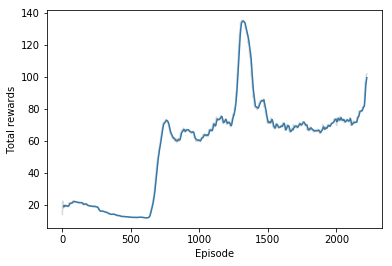

In [16]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

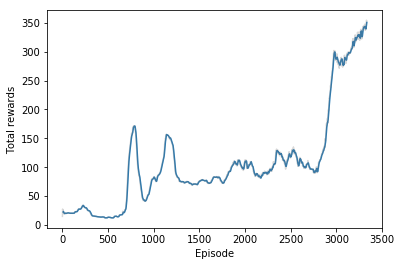

In [27]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

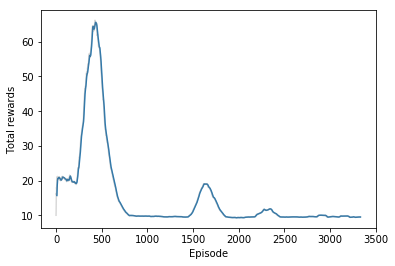

In [24]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

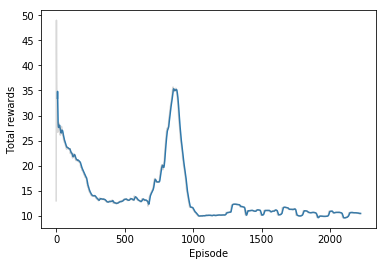

In [26]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

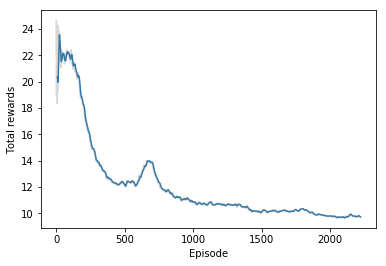

In [16]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

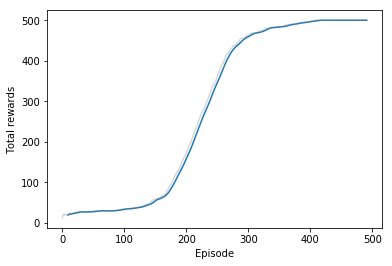

In [62]:
# eps, arr = np.array(episode_rewards_list).T
# smoothed_arr = running_mean(arr, 10)
# plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
# plt.plot(eps, arr, color='grey', alpha=0.3)
# plt.xlabel('Episode')
# plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

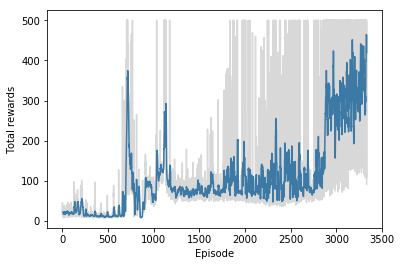

In [29]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

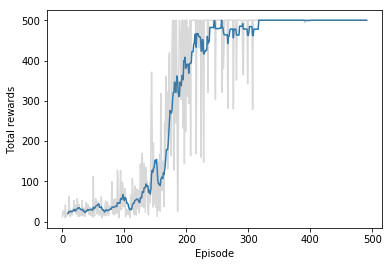

In [63]:
# eps, arr = np.array(rewards_list).T
# smoothed_arr = running_mean(arr, 10)
# plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
# plt.plot(eps, arr, color='grey', alpha=0.3)
# plt.xlabel('Episode')
# plt.ylabel('Total rewards')

In [19]:
eps, arr = np.array(gloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

In [ ]:
eps, arr = np.array(dloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

## Testing

Let's checkout how our trained agent plays the game.

In [36]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(1):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                print('total_reward: {}'.format(total_reward))
                break
                
env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


total_reward: 500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.